<div align='center'>
    <h1>Predicting Subjective Accessment of General Health</h1>
    Flor Cabral, Alijah O'Connor <br>
    CSCI3022 - Data Science, Spring 2019
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy

import sklearn
import sklearn.neighbors
import sklearn.linear_model
import sklearn.discriminant_analysis
import sklearn.model_selection as model_selection
import sklearn.ensemble
import sklearn.preprocessing


# Module for extra functions we wrote
from extra_functions.functions import (general_health_reclasser, visualize, visualize_categorical, kde_by_category,
                                       print_metrics)

# I. Table of Contents
<a href='#II.-Introduction'>II. Introduction</a><br>
<a href='#III.-Exploring-Laboratory-based-Data'>III. Exploring Laboratory-based Data</a><br>
<a href='#IV.-Exploring-Sociological-based-Data'>IV. Exploring Sociological-based Data</a><br>
<a href='#V.-Conclusion,-Discussion,-and-Future-Plans'>V. Conclusion, Discussion, and Future Plans</a><br>
<a href='#VI.-References'>VI. References</a><br>


# II. Introduction

Assessing subjective feelings (e.g. general health, quality of life, etc) has been an important task in medicine for as long as the profession has existed.  Considering that a core goal in medicine seeks to restore positive subjective perceptions and/or prevent negative subjective perceptions in the subjects, the salience of accurate measurements is not hard to overstate.  As with any subjective assessment, however, a number of biases can introduce a large amount of arbitrary variance to the measurements.  There have been several attempts to standardize measurements of subjective experience using various survey questions--one example is called the Nottingham Health Profile, an attempt to measure "quality of life" (Hunt, 1985).  To expand to the existing list of subjective-to-objective mapping, we are attempting to predict a particular subjective measurement ("General Health") from CDC health data by building statistical models with laboratory-based data, sociological-based data, and combined subsets of the two.  The general hypothesis for this project is given a certain set of information about a patient, we can determine/predict how they feel about their health (by classifying them into a corresponding category), without explicitly asking them.

## II.a Data Description

#### NHANES Overview
The data used in this study is compiled and propogated by the CDC under the program name National Health and Nutrition Examination Survey (which will herein be referred to as NHANES).  The NHANES program operates annually (though with different pools of participants) with the goal of assessing health and nutrition of the denizens of America.  The data produced by the program is unique because it utilizes biochemical laboratory-based methods, questionnaires, diet, external body measures, and demographics.  This abundance of data is attractive for statisticians and data scientists (or students of the fields, like us) for generating models for all sorts of different outcomes using a number of measurements (referred to as features in data science).

#### Data acquistion
The specific NHANES data used herein is a subset of files and fields from the 2015-2016 collection (https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2015).  This is the most recent release of NHANES data, as it takes years for the researchers to organize, clean, and verify the data from a particular year.
As noted previously, the NHANES data is broken up into several categories (e.g. demographics, laboratory, etc), and each category is subsequently broken up into a number of files which are made up a number of columns corresponding to the particular measurement.  Interestingly, the data files within each category are released to the public in XPT format, which cannot readily be used for analysis in Pandas.  To be able to use these datafiles in our study, we wrote a shell script that coverts the xpt files to csv.  

We have placed the converted files in a github repository here: https://github.com/oconnoag/NHANES_Data.  This repository also contains the compiled files, which will be described shortly.  We opted for having separate repositories for the data and the analyses, because (1) if anyone else would like the download the data themselves in csv format, they can easily clone or zip the repository and (2) this architecture allows for easy reading of the csv files from Github, so there is no need for someone to download the entire datasets to their local machine to view our analysis.  

#### Selecting intial features to compile for consideration
For the compiled data (i.e. the data that we actually analyzed for incorporation in our models), we decided to choose a subset of fators that we surmised would correlate with a subject's general health.  In the data setup files (found here:  https://github.com/oconnoag/NHANES_Data/tree/master/compiled_data), the features we divided between the authors of this study (Alijah and Flor).  Alijah would choose and explore data from the laboratory category, and Flor would choose and explore data from the questionnaire and demographics categories.  By including data from these two disparate fields we get to utilize both quantitative and qualitative features.  What's more, this approach serves as an initial test to target specific factors out of intuition (sort of a proof of concept); however, once these original models are constructed, we may switch gears and generalize our approach by including many more factors.

#### General Health
The general_health field is originally coded as the "HSD010" column in the /Questionnaire/HSQ_I ("General Health Status") file.  The measurements come from subjects answering the question:  "Would you say {your/SP's} health in general is {List Options}?".  The answers are broken up into 5 levels: 1, 2, 3, 4, 5 corresponding to "Excellent", "Very Good", "Good", "Fair", and "Poor", respectively.

#### Laboratory Features Considered
| Filename_NHANES | Filename_Project | Feature_Name_NHANES | Feature_Name_Project | Description |
|------|------|------|------|------|
|   BIOPRO_I  | standard_biochem_profile | LBXSBU | Blood Urea Nitrogen  | Measured from blood in mg/dL |
|   BIOPRO_I  | standard_biochem_profile | LBXSC3SI | Bicarbonate  | Measured from serum in mmol/L |
|   BIOPRO_I  | standard_biochem_profile | LBXSCA | Total Calcium | Measured from serum in mg/dL
|   BIOPRO_I  | standard_biochem_profile | LBXSCH | Cholesterol | Measured from serum in mg/dL
|   BIOPRO_I  | standard_biochem_profile | LBXSCLSI | Chloride | Measured from serum in mmol/L
|   BIOPRO_I  | standard_biochem_profile | LBXSGL | Glucose | Measured from serum in mg/dL
|   BIOPRO_I  | standard_biochem_profile | LBXSIR | Iron | Measured from serum in ug/dL
|   BIOPRO_I  | standard_biochem_profile  | LBXSKSI | Potassium | Measured from serum in mmol/L
|   BIOPRO_I  | standard_biochem_profile  | LBXSNASI | Sodium | Measured from serum in mmol/L
|   BIOPRO_I  | standard_biochem_profile  | LBXSTP | Total Protein | Measured from serum in g/dL
|   BIOPRO_I  | standard_biochem_profile  | LBXSTR | Triglycerides | Measured from serum in mg/dL
|   BIOPRO_I  | standard_biochem_profile  | LBXSUA | Uric acid | Measured from serum in mg/dL
|   TST_I  | sex_steroid_hormone | 	LBXTST | Testosterone | Measured from serum in ng/dL
|   TST_I  | sex_steroid_hormone | 	LBXEST | Estradiol | Measured from serum in pg/dL
|   TST_I  | sex_steroid_hormone | LBXSHBG | Sex Hormone Binding Globulin (SHBG) | Measured from serum in nmol/L
|   GHB_I  | glycohemoglobin | LBXGH | glycohemoglobin | Measured from serum as a percentage (%)


#### Questionnaire/Demographic Features

| Filename_NHANES | Filename_Project | Feature_Name_NHANES | Feature_Name_Project | Description |
|------|------|------|------|------|
|   DEMO_I  | demographics | RIDAGEYR | Age  | Age in years |
|   DEMO_I  | demographics | DMDHHSIZ | People in Household  | Values range 1-7 |
|   DEMO_I  | demographics | INDHHIN2 | Annual household income | Values range 1-15, representing incomes 0 to $100,000+
|   DBQ_I  | diet_and_behavior | DBQ700 | Healthy Diet | Values range from 1-5
|   DBQ_I  | diet_and_behavior | DBD900 | Number of fast food meals past 7 days | Values range from 0 to 21+
|   DBQ_I  | diet_and_behavior | DBD910 | Number of frozen meals past 30 days | Values range from 0 to 90+
|   PAQ_I  | physical_activity | PAQ635 | Walk or bike | Answers are Y/N
|   PAQ_I  | physical_activity  | PAQ650 | Vigorous recreational activities per week | Answers are Y/N
|   PAQ_I  | physical_activity  | PAQ680 | Minutes of sedentary activity per day | Values range from 0 to 1380
|   BMX_I  | body_measures  | BMXBMI | Body Mass Index | Measured in kg/m**2

## II.b Analysis/Modeling Descriptions

#### Data Cleaning
In order to be able to use our data for model generation (and some visualizations like pairplot), there cannot be nan values in any of the columns.  This led to removing some initial features that didn't have enough datapoints from the start. We also removed any conceptually meaningless values from our sets, such as "Don't know" and "Refused". Once we had features from files that had a sufficient # of entries (>6000), we removed all entries that contain any nan values.  For the laboratory set, this reduced the size to ~5500 complete subject profiles. For the sociological/demographic set, the size was reduced to ~4000. Outlier culling was not undertaken in this part of the project, because we don't know just how particular values will affect the construction of the models.  Biology is messy, so it's difficult to determine what constitutes an outlier; however, we may pick some threshold for distance (in standard deviations from the mean) if certain values seem to be skewing the data in drastic ways (like perhaps glucose measurements).

#### Feature Culling
To better focus our attention on certain features, we employed a method of culling the number of features based on the correlation coefficients between each feature and the response variable, 'general_health.'  A threshold of |0.05| was chosen arbitrarily to remove a number of features from the analysis.  

#### Analysis
For each feature in each set of data (i.e. lab or sociological), visualizations were generated to better understand how the data is distributed in each class and also to see the relationship between a feature and 'general_health.'  What's more, a colinearity/inter-feature-correlation assessment was conducted for each using pairplots and heatmaps.
Note that a external module was utilized for modularizing/organizing this project, so details regarding some of the visualizations can only be found within the modules (extra_functions).

#### Possible Models
Our approach lends it well to classificiation, in the machine learning parlance, and because this is a multi-level classification problem, a couple of different models could be considered including K-Nearest Neighbors, logistic regression, discriminant analyses, or even a Random Forest:

* **K-Nearest Neighbors (KNN)** - If we are going to build this model, we'll have to reduce our feature sets to avoid the so-called "curse of dimensionality" (the fact that KNN typically does not perform well with many data points from many features due to its reliance on "locality").


* **Logistic Regression** - 


* **Discriminant Analyses** -  Discriminant Analyses are similiar in setup as Logistic Regression, except they use Bayesian stastistics to determine their classifications. This is one of the most popular approaches for classification problems dealing with more than two classes.  One interesting feature of a discriminant analysis is the the discriminant plot, which can plot the classification bounds in K - 1 dimensional space (where K is the number of classes being considered).  In our problem here, since we have 5 classes, a 4D would be hard to visualize; however, there are techniques for reducing the space to a "best" 2D plot.  Moreover, if we were to reduce the number of classes to 3 (say, Levels 1-2 become "Above Average", Level 3 becomes "Average", and levels 4-5 become "Below Average"), then we can easily see how our classification boundaries are being drawn.  More on class reduction in the discussion section.
    - One concern with performing a Linear or Quadratic Discriminant Analysis is the normality assumption of the data within each class.  Some of the features in the datasets appear to be "non-exactly normal" (at least by themselves).  However, It is difficult to assess the multinormality of the data (especially with many features).  This facet doesn't prohibit us from using a normality-assuming discriminant analysis; however, we way never reach an optimal solution with these models.
    

* **Random Forest** - a technique that extends on another technique called a decision tree.  Decision trees on their own tend to be very good at working with the training data, but are generally less great with the test data (i.e. they overfit the training data).  Random Forests provide a method for taking the predictive power of a decision tree while adding flexibility to it by using another technique called bagging (<u>b</u>ootstrapping the data and <u>ag</u>gregat<u>ing</u>).  Breifly, the process refers to simulating new data from the original data and then creating many decision trees with a certain subset of the total features (hence the name, Random Forest).  Using all of those decision trees, new data can be inputted and adjudicated (classified) by the the jury of trees in the forest.  The class with the highest number of votes gets the classification.  Interestingly, one can obtain an "Feature Importance" report from many popular machine learning packages when generating Random Forests, allowing one to assess the contribution of each of the features to the classifications (Donges, 2018).
    - Since this is a technique that was not covered in our class, some of the aspects of Decision Trees will need to be figured out by the team including handling of continuous features (since many of the features in the NHANES Data are continuous) and construction, tuning, & optimization in Python.

Moreover, as mentioned previously, we are looking to build different models in sets using (a) laboratory data only, (b) sociological data only, and (c) finally the combined datasets.


# III. Exploring Laboratory-based Data

In [2]:
lab_data_url = 'https://raw.githubusercontent.com/oconnoag/NHANES_Data/master/compiled_data/alijah_compiled_raw.csv'
lab_raw_data = pd.read_csv(lab_data_url)

### Data Preprocessing

#### Column Renaming

In [3]:
lab_processed_data_a = lab_raw_data.copy()

In [4]:
lab_processed_data_b = lab_processed_data_a.rename(columns={'HSD010': 'general_health',
                                                    'LBXTST': 'testosterone',
                                                    'LBXEST': 'estradiol',
                                                    'LBXSHBG': 'sex_hormone_binding_globulin',
                                                    'LBXGH': 'glycohemoglobin',
                                                    'LBXSBU': 'blood_urea_nitrogen',
                                                    'LBXSC3SI': 'bicarbonate',
                                                    'LBXSCA': 'calcium',
                                                    'LBXSCH': 'cholesterol',
                                                    'LBXSCLSI': 'chloride', 
                                                    'LBXSGL': 'glucose',
                                                    'LBXSIR': 'iron',
                                                    'LBXSKSI': 'potassium',
                                                    'LBXSNASI': 'sodium',
                                                    'LBXSTP': 'total_protein',
                                                    'LBXSTR': 'triglycerides',
                                                    'LBXSUA': 'uric_acid'})

In [5]:
lab_processed_data_c = lab_processed_data_b.copy()
lab_processed_data_c['general_health'] = lab_processed_data_b['general_health']\
                                            .apply(lambda x: general_health_reclasser(x))

#### Cleaning Data

In [6]:
lab_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6744 entries, 0 to 6743
Data columns (total 18 columns):
SEQN        6744 non-null float64
HSD010      6166 non-null float64
LBXTST      6235 non-null float64
LBXEST      6186 non-null float64
LBXSHBG     6039 non-null float64
LBXGH       6326 non-null float64
LBXSBU      6255 non-null float64
LBXSC3SI    6257 non-null float64
LBXSCA      6257 non-null float64
LBXSCH      6254 non-null float64
LBXSCLSI    6257 non-null float64
LBXSGL      6257 non-null float64
LBXSIR      6253 non-null float64
LBXSKSI     6257 non-null float64
LBXSNASI    6257 non-null float64
LBXSTP      6253 non-null float64
LBXSTR      6254 non-null float64
LBXSUA      6254 non-null float64
dtypes: float64(18)
memory usage: 948.5 KB


In [7]:
lab_processed_data = lab_processed_data_c.copy()

In [8]:
# Drop any subject that did not have a particular lab test performed
lab_processed_data = lab_processed_data.dropna()

In [9]:
lab_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5503 entries, 0 to 6743
Data columns (total 18 columns):
SEQN                            5503 non-null float64
general_health                  5503 non-null float64
testosterone                    5503 non-null float64
estradiol                       5503 non-null float64
sex_hormone_binding_globulin    5503 non-null float64
glycohemoglobin                 5503 non-null float64
blood_urea_nitrogen             5503 non-null float64
bicarbonate                     5503 non-null float64
calcium                         5503 non-null float64
cholesterol                     5503 non-null float64
chloride                        5503 non-null float64
glucose                         5503 non-null float64
iron                            5503 non-null float64
potassium                       5503 non-null float64
sodium                          5503 non-null float64
total_protein                   5503 non-null float64
triglycerides                

### Data Exploration

#### General Health Distribution
- In the 5 level set up, there are many fewer 1's and 5's than 3's

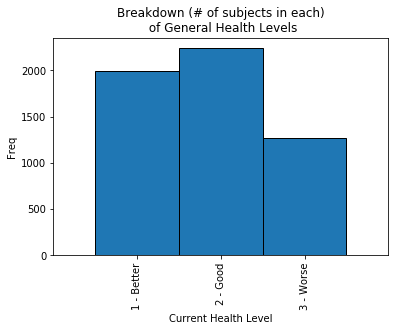

In [74]:
lab_processed_data['general_health'].hist(grid=False, bins=np.arange(0,7,1)-0.5, ec='k')
plt.xlim([0,4])
plt.title('Breakdown (# of subjects in each)\n of General Health Levels')
plt.ylabel("Freq")
plt.xlabel("Current Health Level")
plt.xticks(np.arange(1,4), ['1 - Better', '2 - Good', '3 - Worse'],
          rotation=90);

#### Column Histograms

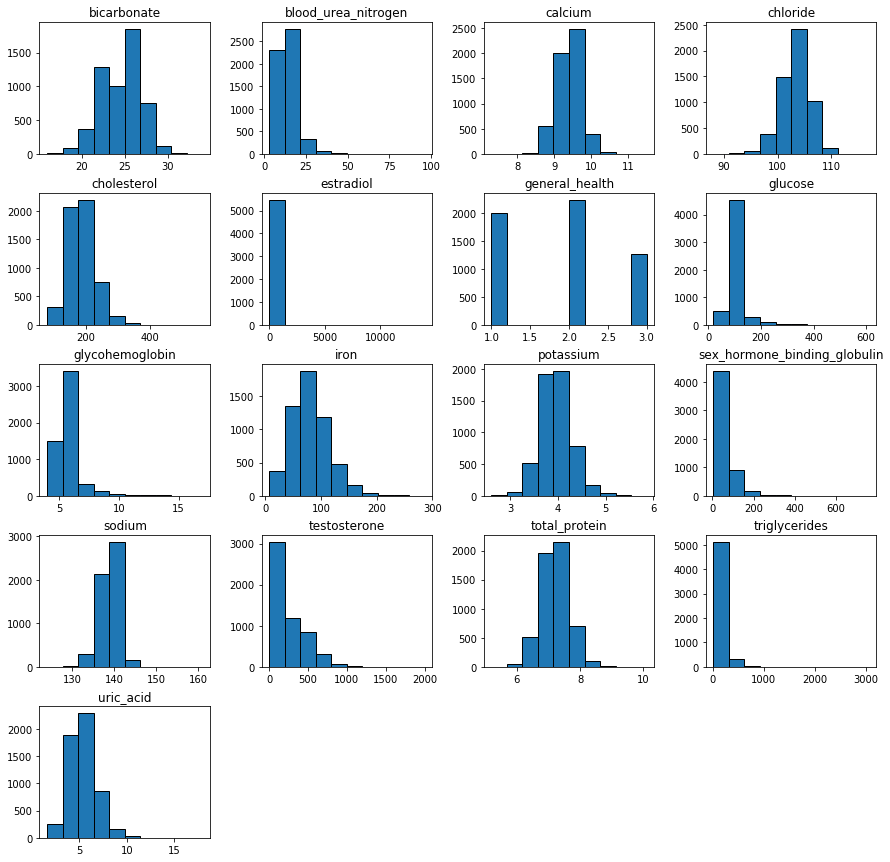

In [11]:
pd.DataFrame.hist(lab_processed_data.drop('SEQN', axis=1), figsize = [15,15], edgecolor='k', grid=False);

### Feature Selection/Culling
Removing features that do not correlate well with general_health variable (threshold at correlation factor < |0.05|)

In [12]:
print("Mean by reported health level:")
display(lab_processed_data.groupby('general_health').mean())
print('\n')
print("Standard Deviation by reported health level:")
lab_processed_data.groupby('general_health').std()

Mean by reported health level:


,SEQN,testosterone,estradiol,sex_hormone_binding_globulin,glycohemoglobin,blood_urea_nitrogen,bicarbonate,calcium,cholesterol,chloride,glucose,iron,potassium,sodium,total_protein,triglycerides,uric_acid
general_health,,,,,,,,,,,,,,,,,
1.0,88765.766149,235.903841,92.126418,64.120686,5.484927,13.906860,24.464196,9.412218,183.255383,103.372058,94.951928,84.486229,3.963595,138.764146,7.182123,125.933400,5.188232
2.0,88669.231010,212.660737,85.921147,58.623530,5.715505,14.046470,24.428954,9.371001,188.300715,103.428954,101.573727,80.497766,3.942413,138.790885,7.200045,153.021001,5.408356
3.0,88690.054416,195.180639,39.285267,54.718241,6.220662,15.149054,24.399842,9.349132,187.982650,103.050473,116.798107,75.240536,3.962823,138.453470,7.217429,167.453470,5.533675




Standard Deviation by reported health level:


,SEQN,testosterone,estradiol,sex_hormone_binding_globulin,glycohemoglobin,blood_urea_nitrogen,bicarbonate,calcium,cholesterol,chloride,glucose,iron,potassium,sodium,total_protein,triglycerides,uric_acid
general_health,,,,,,,,,,,,,,,,,
1.0,2887.526958,251.192567,685.428942,56.002383,0.714268,4.766947,2.063458,0.337889,40.837376,2.648832,27.948469,35.124491,0.329032,1.988433,0.435310,93.936426,1.309426
2.0,2838.005719,237.837561,649.198642,49.438695,0.968210,5.238145,2.118126,0.348243,42.679313,2.779982,35.974718,33.617823,0.320443,2.069440,0.459767,139.269401,1.415306
3.0,2871.219096,226.523007,78.932434,36.820084,1.579290,7.494951,2.404987,0.362083,45.277079,3.132281,58.028123,34.018051,0.356411,2.367275,0.473184,123.346741,1.568140


#### Correlates with general_health
with a marked threshold of |0.05| correlation coefficient (Pearson's r) with general_health <br>

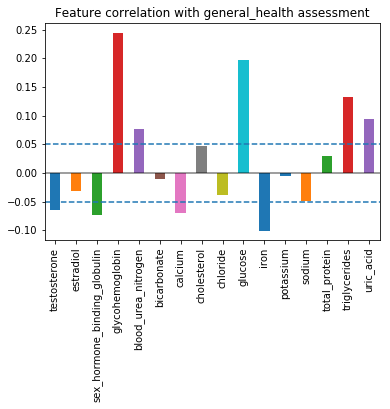

In [13]:
(lab_processed_data.corr()['general_health'][2:]).plot.bar()
plt.axhline(y = 0.05, linestyle='--')
plt.axhline(y=0, linestyle='-', color='k', alpha=0.5)
plt.axhline(y = -0.05, linestyle='--')
plt.title("Feature correlation with general_health assessment");

In [14]:
lab_corr_df = pd.DataFrame(lab_processed_data.corr()['general_health'][2:]).abs().sort_values(by='general_health', 
                                                                           ascending=False)
display(lab_corr_df)

,general_health
glycohemoglobin,0.244153
glucose,0.196361
triglycerides,0.132909
iron,0.100573
uric_acid,0.094559
blood_urea_nitrogen,0.076583
sex_hormone_binding_globulin,0.073113
calcium,0.070629
testosterone,0.065035
sodium,0.049557


### Analyze features that correlate with general_health
- Keeping only the features that make the |0.05| correlation-coefficient threshold for correlating with general_health (see the lab_corr_df above)

In [15]:
lab_correlating_features = list(lab_corr_df[lab_corr_df['general_health'] > 0.05].index)
print("Features to keep are:", lab_correlating_features)
lab_selected_features = lab_processed_data[['general_health'] + lab_correlating_features]
lab_selected_features.head()

Features to keep are: ['glycohemoglobin', 'glucose', 'triglycerides', 'iron', 'uric_acid', 'blood_urea_nitrogen', 'sex_hormone_binding_globulin', 'calcium', 'testosterone']


,general_health,glycohemoglobin,glucose,triglycerides,iron,uric_acid,blood_urea_nitrogen,sex_hormone_binding_globulin,calcium,testosterone
0,2.0,7.0,94.0,158.0,70.0,4.2,13.0,42.86,9.8,367.00
1,1.0,5.5,94.0,170.0,161.0,7.0,10.0,29.04,9.8,505.00
2,3.0,5.8,103.0,299.0,72.0,7.3,26.0,27.02,9.7,104.00
3,2.0,5.6,63.0,93.0,43.0,5.4,13.0,62.77,8.9,41.00
5,2.0,5.9,97.0,52.0,75.0,4.9,25.0,55.08,9.3,5.55


### Visualizing Individual Columns with general_health

#### Glycohemoglobin
- Noticeable trend of higher glycohemoglobin levels correlating with lower-perception of general health
- Each group of general_health looks roughly normal in glycohemoglobin distribution, however, long right tails do seem to be present

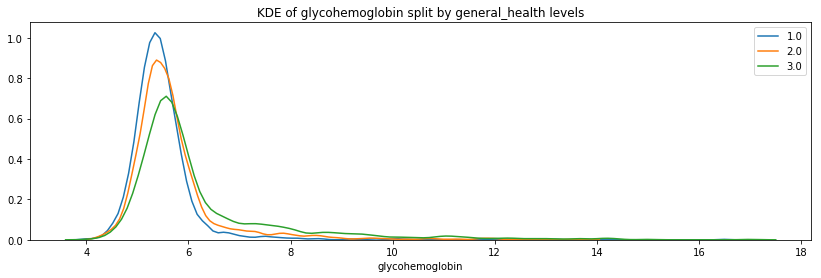

In [16]:
kde_by_category(lab_selected_features, 'general_health', 'glycohemoglobin')

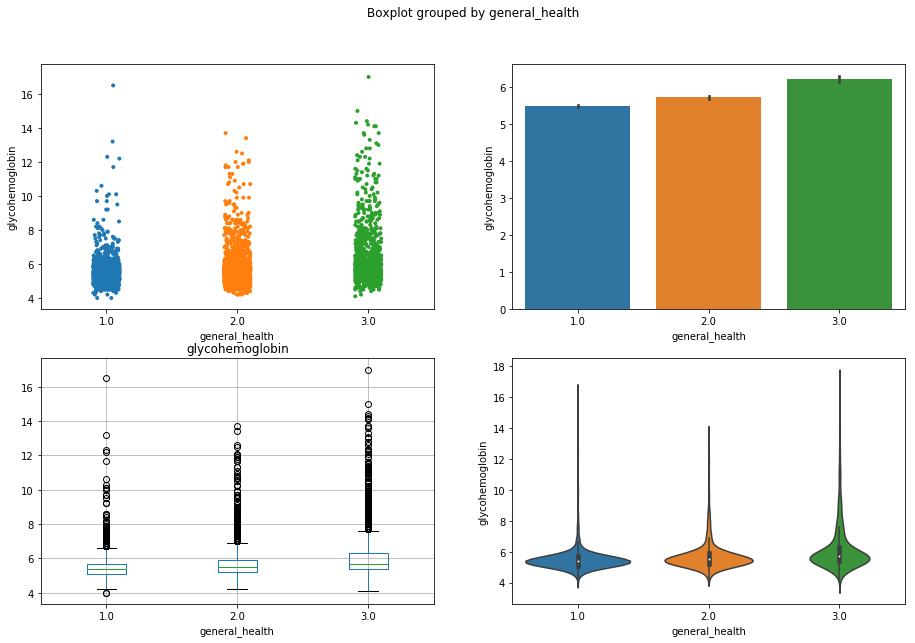

In [17]:
visualize(lab_selected_features, 'general_health', 'glycohemoglobin')

#### Glucose
- Noticeable trend of higher glucose levels correlating with lower-perception of general health
- Fair amount of variance in 'poor' category
- Roughly normally distributed (long right tails)
- Possible outliers present

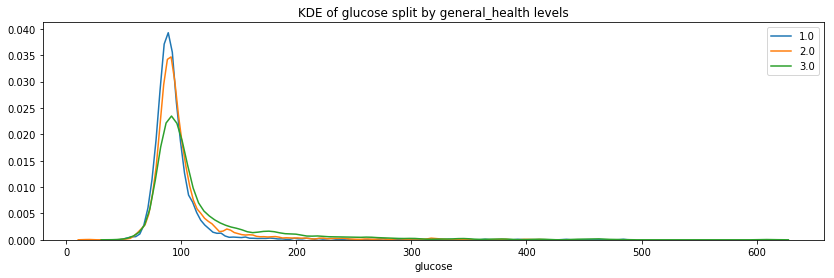

In [18]:
kde_by_category(lab_selected_features, 'general_health', 'glucose')

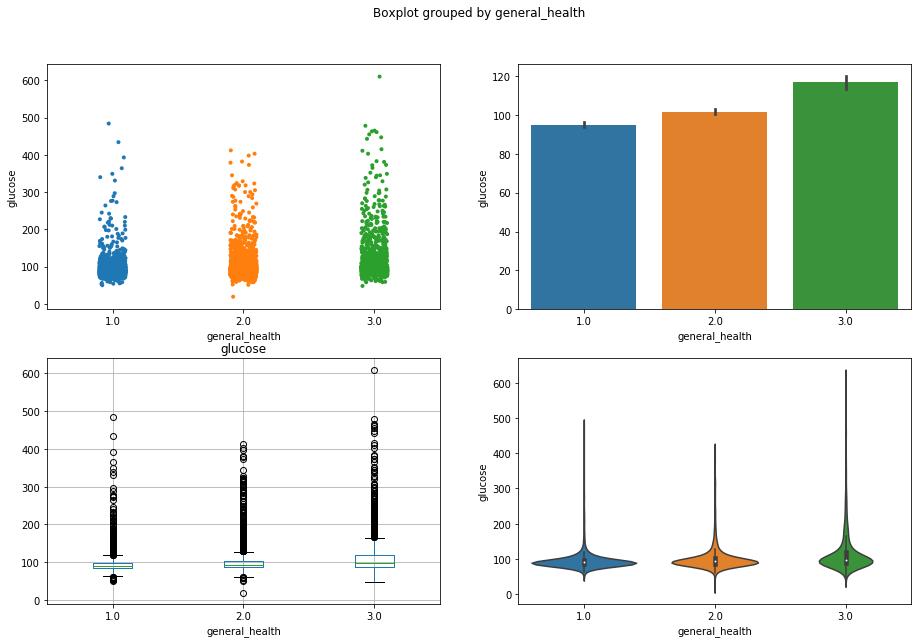

In [19]:
visualize(lab_selected_features, 'general_health', 'glucose')

#### Triglycerides
- Noticeable trend of higher triglycerides levels correlating with lower-perception of general health
- Fair amount of variance in this data
- Roughly normally distributed, except levels 4 and 5 seem to have a small secondary peak just under 500 units (possibly bimodal)
- Possible outliers present

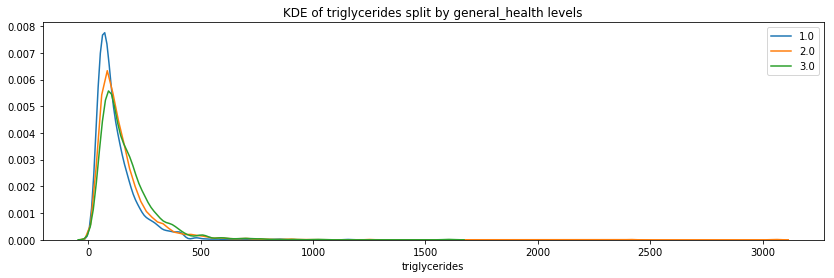

In [20]:
kde_by_category(lab_selected_features, 'general_health', 'triglycerides')

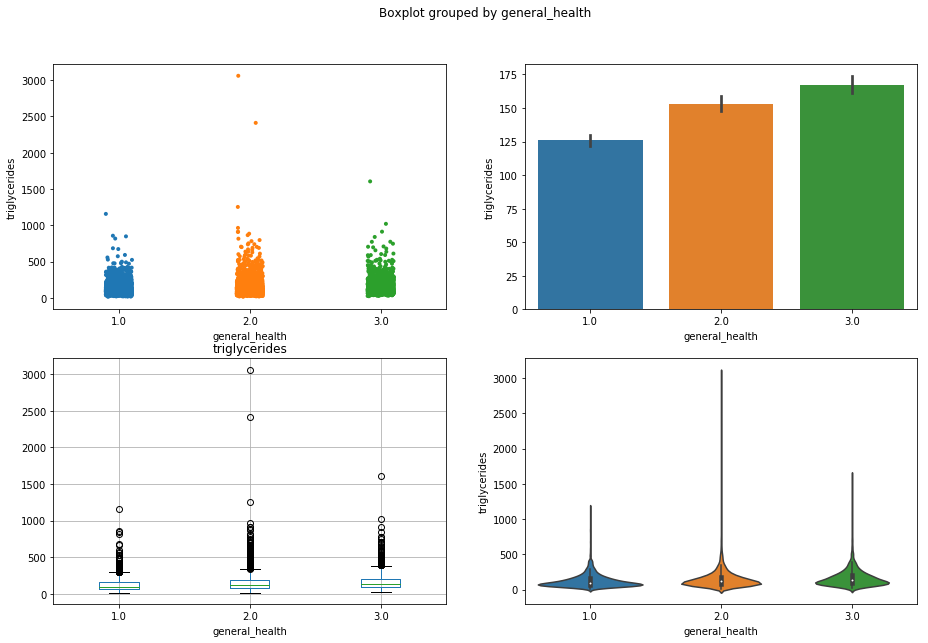

In [21]:
visualize(lab_selected_features, 'general_health', 'triglycerides')

#### Iron
- Noticeable trend of lower iron levels correlating with lower-perception of general health
- Distributions look roughly normal
- Fair amount of variance for the poor health category

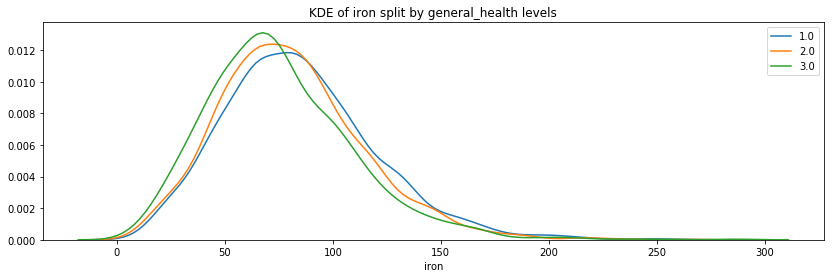

In [22]:
kde_by_category(lab_selected_features, 'general_health', 'iron')

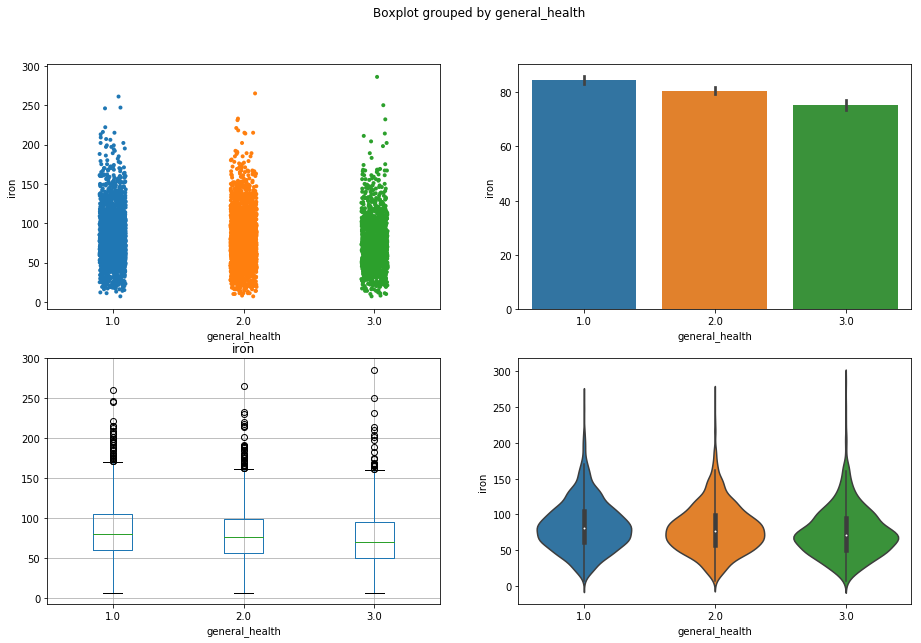

In [23]:
visualize(lab_selected_features, 'general_health', 'iron')

#### Uric Acid
- Noticeable trend of higher uric acid levels correlating with lower-perception of general health
- Roughly normal (long right tail)
- Fair amount of variance in this data (particularly the 'poor' category)

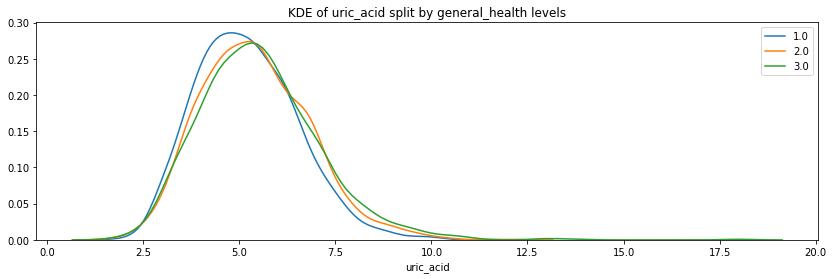

In [24]:
kde_by_category(lab_selected_features, 'general_health', 'uric_acid')

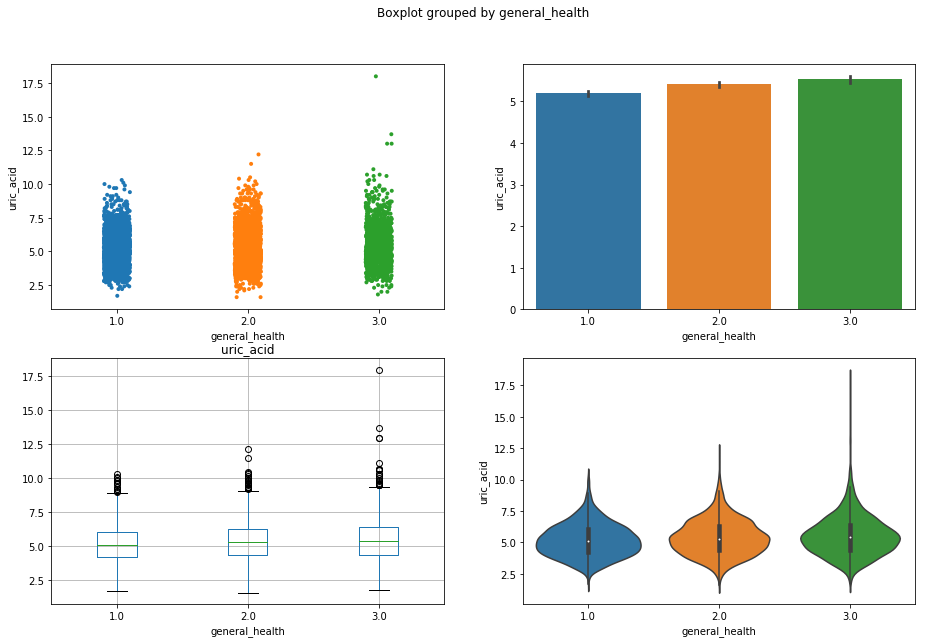

In [25]:
visualize(lab_selected_features, 'general_health', 'uric_acid')

#### Blood Urea Nitrogen
- Noticeable trend of higher Blood-Urea-Nitrogen levels correlating with lower-perception of general health
- Roughly normal; however, levels 4 and 5 appear to auxilliary peaks (and long right tails on all)
- Fair amount of variance in this data (particularly the 'poor' category)

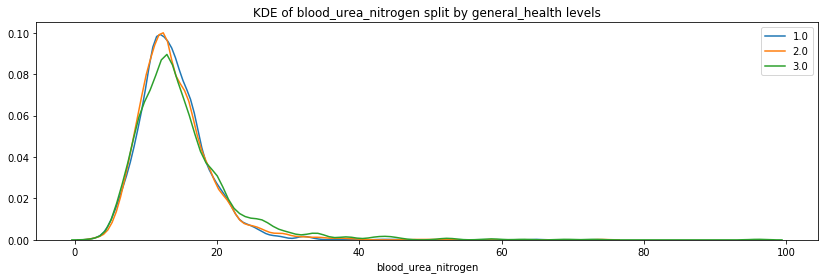

In [26]:
kde_by_category(lab_selected_features, 'general_health', 'blood_urea_nitrogen')

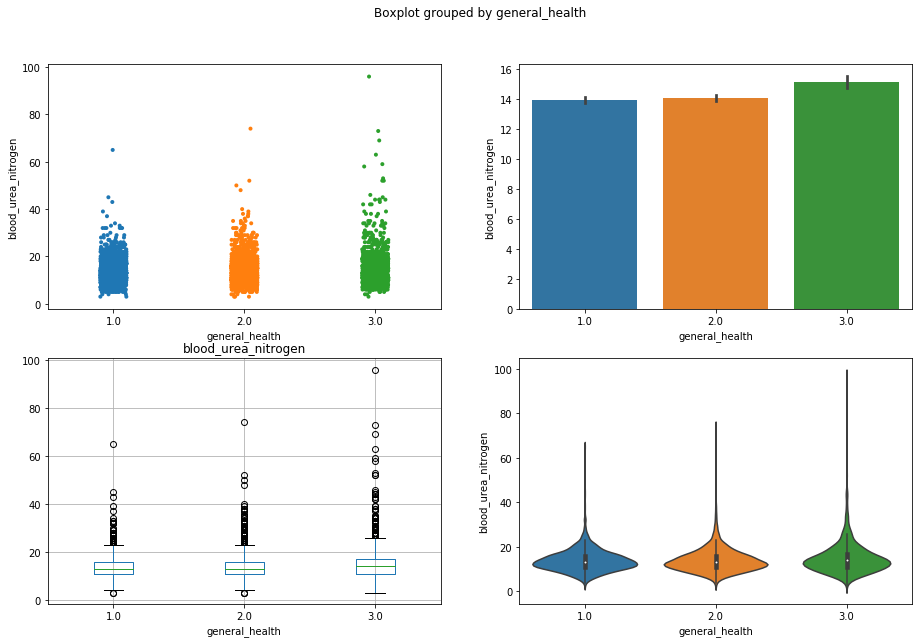

In [27]:
visualize(lab_selected_features, 'general_health', 'blood_urea_nitrogen')

#### Testosterone
- Noticeable trend of lower testerone levels correlating with lower-perception of general health
- Bimodal distribution, both which seem to be normal by themselves.
- Fair amount of variance in this data as a whole
- Possible outliers

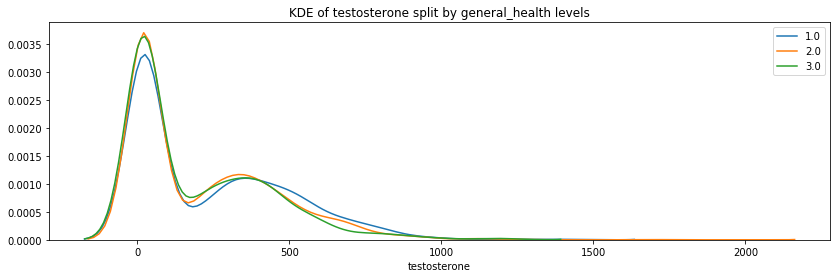

In [28]:
kde_by_category(lab_selected_features, 'general_health', 'testosterone')

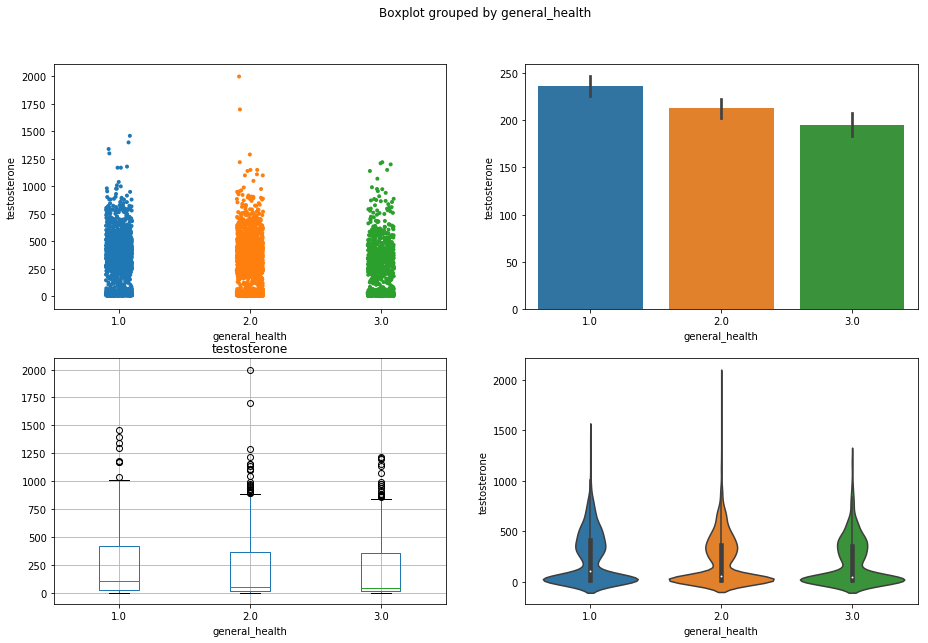

In [29]:
visualize(lab_selected_features, 'general_health', 'testosterone')

#### Calcium
- Statistical trend of lower calcium levels correlating with lower-perception of general health
    - May be difficult to visualize because the variance in the data is much smaller than the variances of other features 
- Roughly normal distributions

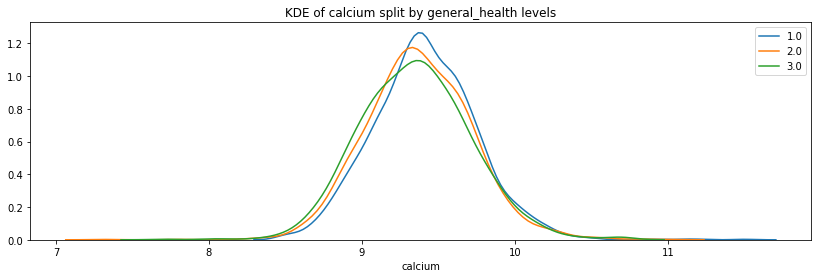

In [30]:
kde_by_category(lab_selected_features, 'general_health', 'calcium')

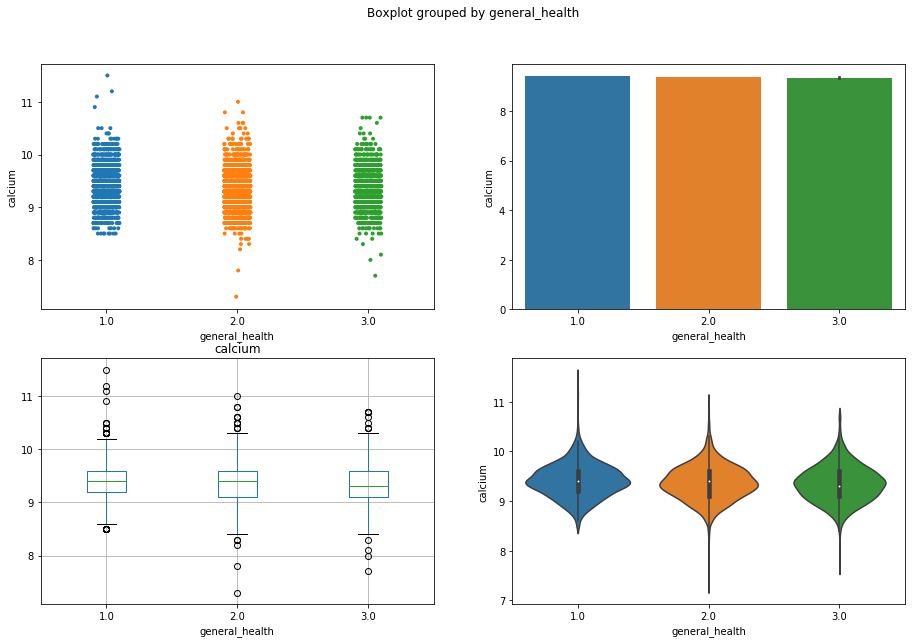

In [31]:
visualize(lab_selected_features, 'general_health', 'calcium')

#### Sex Hormone Binding Globulin
- Fair amount of variance in this data (particularly the 'exellent' and 'poor' categories)
- Overall trend appears to be lower SHBG, lower perception of general health; however, the uptick in SHBG for the 'poor' category may lead to this feature not being as helpful in the models
- Roughly normal distributions (long right tails)

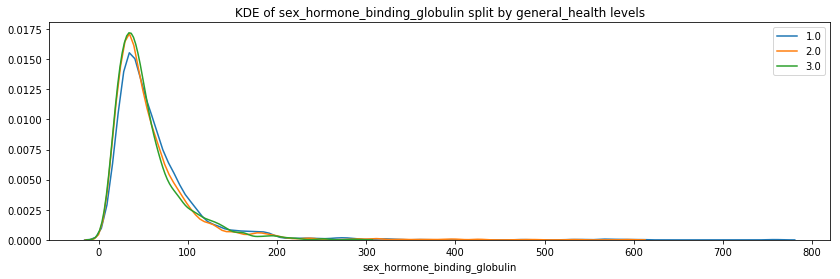

In [32]:
kde_by_category(lab_selected_features, 'general_health', 'sex_hormone_binding_globulin')

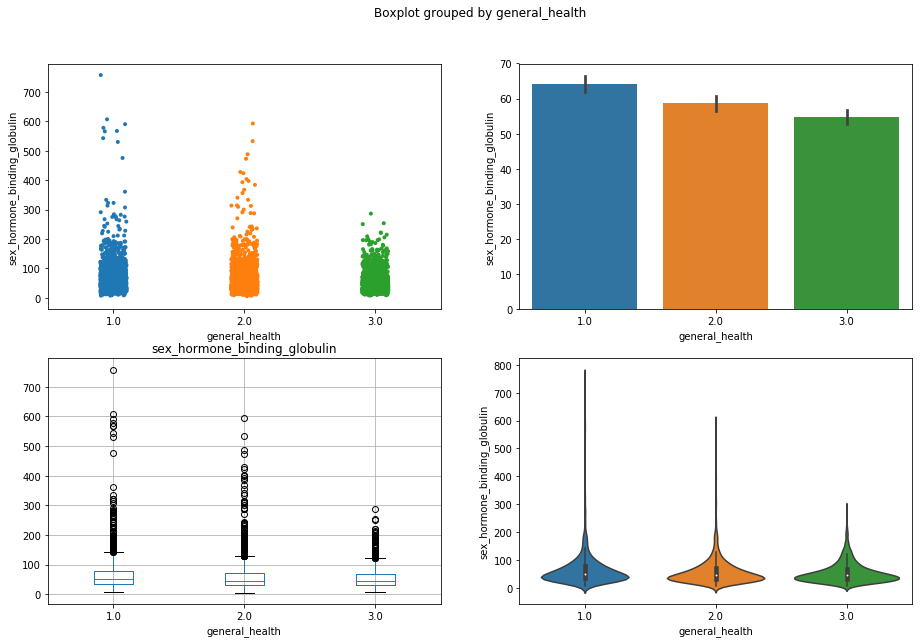

In [33]:
visualize(lab_selected_features, 'general_health', 'sex_hormone_binding_globulin')

### Any Colinearity?
** All Correlation Coefficients presented are Pearson's r ** <br>
The most concerning trends:
- Glucose and Glycohemoglobin are highly correlated (.79)
- Uric acid is correlated with a number of other features (including nearly |0.30| for blood_urea_nitrogen, SHBG, and testosterone
- Testosterone is correlated with iron at .29
- Triglycerides are correlated with Glucose and Glycohemoglib at ~0.2

#### Pairplot of variables meeting the 0.05 correlation threshold

In [36]:
# sns.pairplot(lab_selected_features, hue='general_health', )

#### Heatmap

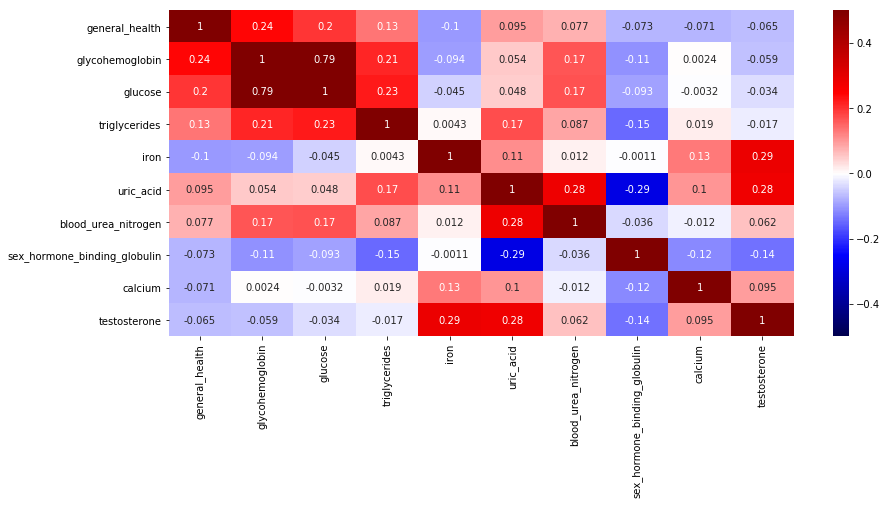

In [37]:
plt.figure(figsize=(14,6))
sns.heatmap(data=lab_selected_features.corr(), vmin=-.5, vmax=.5, cmap='seismic', annot=True);

# Lab Models

#### Priors

In [41]:
lab_selected_features['general_health'].value_counts(normalize=True)

2.0    0.406687
1.0    0.362893
3.0    0.230420
Name: general_health, dtype: float64

#### Data Splitting

In [42]:
lab_selected_features.columns

Index(['general_health', 'glycohemoglobin', 'glucose', 'triglycerides', 'iron',
       'uric_acid', 'blood_urea_nitrogen', 'sex_hormone_binding_globulin',
       'calcium', 'testosterone'],
      dtype='object')

In [44]:
lab_y, lab_x = patsy.dmatrices('C(general_health, [[1],[2],[3]]) ~ 0 + glycohemoglobin + glucose + triglycerides + iron + uric_acid + blood_urea_nitrogen + testosterone + calcium + sex_hormone_binding_globulin', 
                               data=lab_selected_features)

In [45]:
lab_X_train, lab_X_test, lab_y_train, lab_y_test = model_selection.train_test_split(lab_x, 
                                                                    lab_y,
                                                                    train_size=0.75, test_size=0.25)

#### knn non-scaled

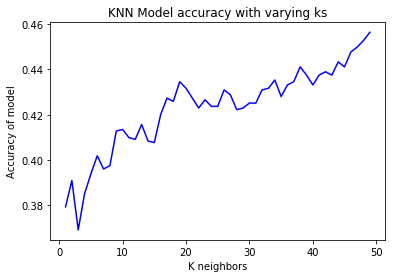

In [46]:
# lab_knn_training_scores = []
lab_knn_testing_scores = []
lab_ks = range(1,50)

for k in lab_ks:
    lab_knn_xpt = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    lab_knn_mod_xpt = lab_knn_xpt.fit(lab_X_train, lab_y_train.ravel())

#     lab_knn_training_scores.append(lab_knn_mod_xpt.score(lab_X_train, lab_y_train))
    lab_knn_testing_scores.append(lab_knn_mod_xpt.score(lab_X_test, lab_y_test))

# plt.plot(lab_ks, lab_knn_training_scores, 'r-')
plt.plot(lab_ks, lab_knn_testing_scores, 'b-')
plt.xlabel("K neighbors")
plt.ylabel("Accuracy of model")
plt.title("KNN Model accuracy with varying ks");

In [47]:
lab_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=49, n_jobs=-1)
lab_knn_mod = lab_knn.fit(lab_X_train, lab_y_train.ravel())

lab_knn_pred = lab_knn.predict(lab_X_test)
print_metrics(lab_knn_mod, lab_X_test, lab_y_test, lab_knn_pred)

Score of the model is 0.4563953488372093

Confusion Matrix: 

[[287 199   8]
 [255 305  26]
 [ 94 166  36]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.45      0.58      0.51       494
        2.0       0.46      0.52      0.49       586
        3.0       0.51      0.12      0.20       296

avg / total       0.47      0.46      0.43      1376



#### KNN with Scaled Data

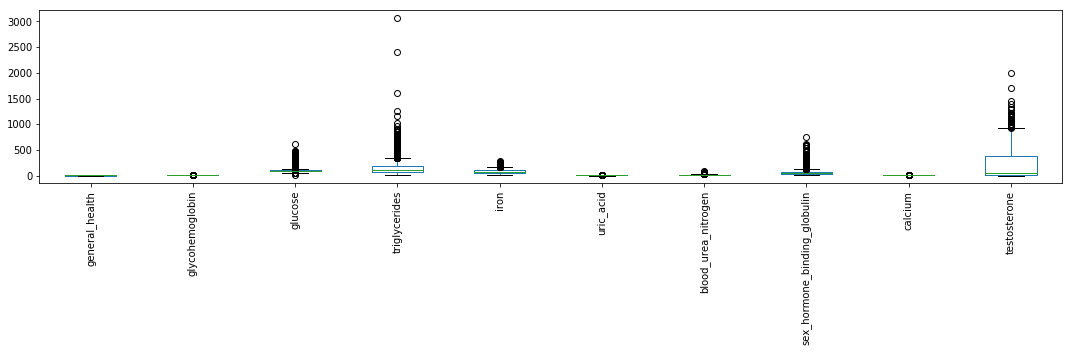

In [48]:
knn_fig, knn_ax = plt.subplots(figsize=(15,3))
lab_selected_features.plot.box(ax = knn_ax)
plt.tight_layout()
plt.xticks(rotation=90);

In [49]:
scaled_lab_X = sklearn.preprocessing.scale(lab_x, axis=0)

['glycohemoglobin',
 'glucose',
 'triglycerides',
 'iron',
 'uric_acid',
 'blood_urea_nitrogen',
 'testosterone',
 'calcium',
 'sex_hormone_binding_globulin']

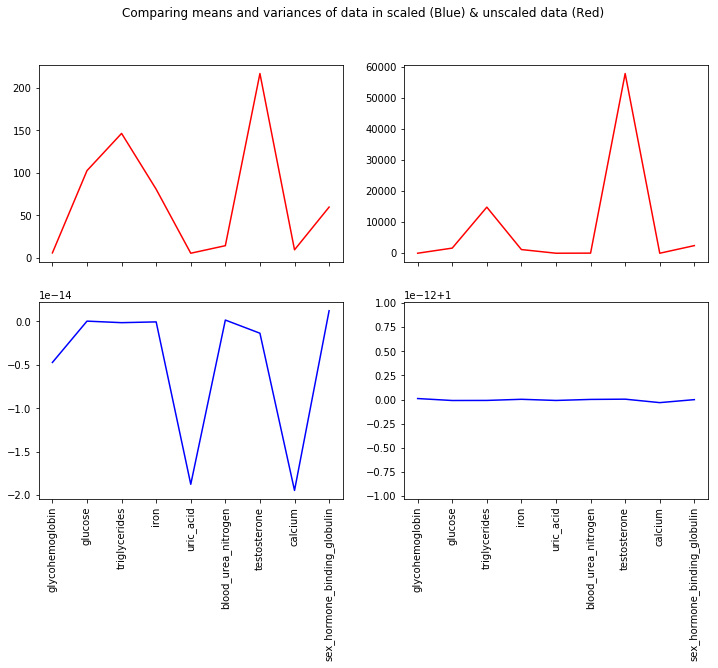

In [151]:
fig,lab_knn_ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharex=True)
plt.xticks(np.arange(0, lab_x.shape[1]), 
          np.array(lab_x.design_info.column_names),
          rotation=90)

lab_knn_ax[0][0].plot(np.mean(lab_x, axis=0), 'r')

plt.sca(lab_knn_ax[1][0])
lab_knn_ax[1][0].plot(np.mean(scaled_lab_X, axis=0), 'b')
plt.xticks(np.arange(0, lab_x.shape[1]), 
          np.array(lab_x.design_info.column_names),
          rotation=90)

lab_knn_ax[0][1].plot(np.var(lab_x, axis=0), 'r')
lab_knn_ax[1][1].plot(np.var(scaled_lab_X, axis=0), 'b')

plt.suptitle("Comparing means and variances of data in scaled (Blue) & unscaled data (Red)");

In [157]:
(scaled_lab_X_train,
 scaled_lab_X_test,
 scaled_lab_y_train,
 scaled_lab_y_test) = model_selection.train_test_split(scaled_lab_X, 
                                                        lab_y,
                                                        train_size=0.75, test_size=0.25)

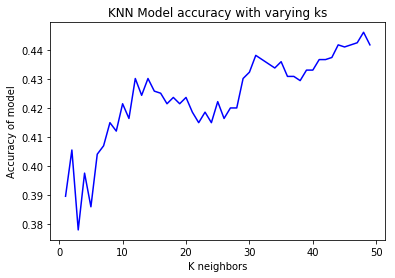

In [153]:
lab_knn_testing_scores = []
lab_ks = range(1,50)

for k in lab_ks:
    lab_knn_xpt = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    lab_knn_mod_xpt = lab_knn_xpt.fit(scaled_lab_X_train, scaled_lab_y_train.ravel())

    lab_knn_testing_scores.append(lab_knn_mod_xpt.score(scaled_lab_X_test, scaled_lab_y_test))

plt.plot(lab_ks, lab_knn_testing_scores, 'b-')
plt.xlabel("K neighbors")
plt.ylabel("Accuracy of model")
plt.title("KNN Model accuracy with varying ks");

In [158]:
scaled_lab_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
scaled_lab_knn_mod = scaled_lab_knn.fit(scaled_lab_X_train, scaled_lab_y_train.ravel())

scaled_lab_knn_pred = scaled_lab_knn.predict(scaled_lab_X_test)
print_metrics(scaled_lab_knn_mod, scaled_lab_X_test, scaled_lab_y_test, scaled_lab_knn_pred)

Score of the model is 0.43023255813953487

Confusion Matrix: 

[[265 244  21]
 [212 278  56]
 [ 85 166  49]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.47      0.50      0.49       530
        2.0       0.40      0.51      0.45       546
        3.0       0.39      0.16      0.23       300

avg / total       0.43      0.43      0.42      1376



#### Logistic Regression

In [170]:
lab_logreg_y, lab_logreg_x = patsy.dmatrices('C(general_health, [[1],[2],[3]]) ~ 0 + glycohemoglobin + glucose + triglycerides + iron + uric_acid + blood_urea_nitrogen + testosterone + calcium + sex_hormone_binding_globulin', 
                               data=lab_selected_features)

In [171]:
(lab_logreg_X_train, lab_logreg_X_test, 
 lab_logreg_y_train, lab_logreg_y_test) = model_selection.train_test_split(lab_logreg_x, 
                                                                    lab_logreg_y,
                                                                    train_size=0.75, test_size=0.25)

In [172]:
lab_logreg = sklearn.linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')
lab_logreg_model = lab_logreg.fit(lab_logreg_X_train, lab_logreg_y_train.ravel())
lab_logreg_pred = lab_logreg.predict(lab_logreg_X_test)

print_metrics(lab_logreg_model, lab_logreg_X_test, lab_logreg_y_test, lab_logreg_pred)

Score of the model is 0.47238372093023256

Confusion Matrix: 

[[251 258   7]
 [174 352  28]
 [ 54 205  47]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.52      0.49      0.50       516
        2.0       0.43      0.64      0.51       554
        3.0       0.57      0.15      0.24       306

avg / total       0.50      0.47      0.45      1376



In [58]:
# llph = lab_logreg_model.predict_proba(lab_logreg_X_test)

# llph_pred = []

# for pcts in llph:
#     if pcts[0] > 0.15:
#         llph_pred.append(1)
#     elif pcts[4] > 0.15:
#         llph_pred.append(5)
#     elif pcts[1] > 0.30:
#         llph_pred.append(2)
#     elif pcts[3] > 0.30:
#         llph_pred.append(4)
#     else:
#         llph_pred.append(list(pcts).index(max(pcts)) + 1)
    
# plt.hist(llph_pred, bins=5)

# print_metrics(lab_logreg_model, lab_logreg_X_test, lab_logreg_y_test, np.array(llph_pred))

#### Scaled Logistic Regression

In [60]:
lab_logreg_y, lab_logreg_x = patsy.dmatrices('C(general_health, [[1],[2],[3]]) ~ 0 + glycohemoglobin + glucose + triglycerides + iron + uric_acid + blood_urea_nitrogen + testosterone + calcium + sex_hormone_binding_globulin', 
                               data=lab_selected_features)

In [177]:
(lab_logreg_X_train, lab_logreg_X_test,
 lab_logreg_y_train, lab_logreg_y_test) = model_selection.train_test_split(sklearn.preprocessing.scale(lab_logreg_x),
                                                                           lab_logreg_y,
                                                                           train_size=0.75, test_size=0.25)

In [178]:
lab_logreg = sklearn.linear_model.LogisticRegression(penalty='l2', C=0.1)
lab_logreg_model = lab_logreg.fit(lab_logreg_X_train, lab_logreg_y_train.ravel())
lab_logreg_pred = lab_logreg.predict(lab_logreg_X_test)

print_metrics(lab_logreg_model, lab_logreg_X_test, lab_logreg_y_test, lab_logreg_pred)

Score of the model is 0.46875

Confusion Matrix: 

[[270 234  14]
 [182 329  33]
 [ 64 204  46]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.52      0.52      0.52       518
        2.0       0.43      0.60      0.50       544
        3.0       0.49      0.15      0.23       314

avg / total       0.48      0.47      0.45      1376



#### LDA

In [179]:
lab_lda_y, lab_lda_x = patsy.dmatrices('C(general_health, [[1],[2],[3]]) ~ 0 + glycohemoglobin + glucose + triglycerides + iron + uric_acid + blood_urea_nitrogen + testosterone + calcium + sex_hormone_binding_globulin', 
                               data=lab_selected_features)

In [182]:
lab_lda_X_train, lab_lda_X_test, lab_lda_y_train, lab_lda_y_test = model_selection.train_test_split(lab_lda_x, 
                                                                    lab_lda_y,
                                                                    train_size=0.75, test_size=0.25)

In [183]:
lab_lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lab_lda_model = lab_lda.fit(lab_lda_X_train, lab_lda_y_train.ravel())
lab_lda_pred = lab_lda.predict(lab_lda_X_test)

print_metrics(lab_lda_model, lab_lda_X_test, lab_lda_y_test, lab_lda_pred)

Score of the model is 0.4752906976744186

Confusion Matrix: 

[[254 246  14]
 [182 339  31]
 [ 57 192  61]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.52      0.49      0.50       514
        2.0       0.44      0.61      0.51       552
        3.0       0.58      0.20      0.29       310

avg / total       0.50      0.48      0.46      1376



#### QDA

In [81]:
lab_qda_y, lab_qda_x = patsy.dmatrices('C(general_health, [[1],[2],[3]]) ~ 0 + glycohemoglobin + glucose + triglycerides + iron + uric_acid + blood_urea_nitrogen + testosterone + calcium + sex_hormone_binding_globulin', 
                               data=lab_selected_features)

In [90]:
lab_qda_X_train, lab_qda_X_test, lab_qda_y_train, lab_qda_y_test = model_selection.train_test_split(lab_qda_x, 
                                                                    lab_qda_y,
                                                                    train_size=0.75, test_size=0.25)

In [91]:
lab_qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
lab_qda_model = lab_qda.fit(lab_qda_X_train, lab_qda_y_train.ravel())
lab_qda_pred = lab_qda.predict(lab_qda_X_test)

print_metrics(lab_qda_model, lab_qda_X_test, lab_qda_y_test, lab_qda_pred)

Score of the model is 0.4367732558139535

Confusion Matrix: 

[[402  88  30]
 [349 126  55]
 [174  79  73]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.43      0.77      0.56       520
        2.0       0.43      0.24      0.31       530
        3.0       0.46      0.22      0.30       326

avg / total       0.44      0.44      0.40      1376



#### Random Forest

In [184]:
lab_rf_y, lab_rf_x = patsy.dmatrices('C(general_health, [[1],[2],[3]]) ~ 0 + glycohemoglobin + glucose + triglycerides + iron + uric_acid + blood_urea_nitrogen + testosterone + calcium + sex_hormone_binding_globulin', 
                               data=lab_selected_features)

In [189]:
lab_rf_X_train, lab_rf_X_test, lab_rf_y_train, lab_rf_y_test = model_selection.train_test_split(lab_rf_x, 
                                                                    lab_rf_y,
                                                                    train_size=0.75, test_size=0.25)

In [190]:
lab_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
lab_rf_model = lab_rf.fit(lab_rf_X_train, lab_rf_y_train.ravel())
lab_rf_pred = lab_rf.predict(lab_rf_X_test)

print_metrics(lab_rf_model, lab_rf_X_test, lab_rf_y_test, lab_rf_pred)

Score of the model is 0.45421511627906974

Confusion Matrix: 

[[254 189  33]
 [215 303  58]
 [ 76 180  68]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.47      0.53      0.50       476
        2.0       0.45      0.53      0.49       576
        3.0       0.43      0.21      0.28       324

avg / total       0.45      0.45      0.44      1376



#### Scaled Random Forest

In [197]:
(scaled_lab_rf_X_train, scaled_lab_rf_X_test, 
 scaled_lab_rf_y_train, scaled_lab_rf_y_test) = model_selection.train_test_split(
                                                                    sklearn.preprocessing.scale(lab_rf_x),
                                                                    lab_rf_y,
                                                                    train_size=0.75, test_size=0.25)

In [198]:
scaled_lab_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
scaled_lab_rf_model = scaled_lab_rf.fit(scaled_lab_rf_X_train, scaled_lab_rf_y_train.ravel())
scaled_lab_rf_pred = scaled_lab_rf.predict(scaled_lab_rf_X_test)

print_metrics(scaled_lab_rf_model, scaled_lab_rf_X_test, scaled_lab_rf_y_test, scaled_lab_rf_pred)

Score of the model is 0.4331395348837209

Confusion Matrix: 

[[244 252  24]
 [173 286  76]
 [ 72 183  66]]

----------------------------------------------------------------

Classification Report: 

             precision    recall  f1-score   support

        1.0       0.50      0.47      0.48       520
        2.0       0.40      0.53      0.46       535
        3.0       0.40      0.21      0.27       321

avg / total       0.44      0.43      0.42      1376



# IV. Exploring Sociological-based Data

In [ ]:
socio_data_url = 'https://raw.githubusercontent.com/oconnoag/NHANES_Data/master/compiled_data/flor_compiled_raw.csv'
raw_data = pd.read_csv(socio_data_url)

### Column Renaming

In [ ]:
processed_data_a = raw_data.copy()

In [ ]:
processed_data_b = processed_data_a.rename(columns={'HSD010': 'general_health',
                                                    'RIDAGEYR': 'age',
                                                    'DMDHHSIZ': 'people_in_household',
                                                    'INDHHIN2': 'annual_income',
                                                    'DBQ700': 'healthy_diet',
                                                    'DBD900': 'number_meals_fastfood_past7',
                                                    'DBD910': 'number_frozen_past30',
                                                    'BMXBMI': 'bmi',
                                                    'PAQ635': 'walk_or_bike',
                                                    'PAQ650': 'vigorous_rec', 
                                                    'PAD680': 'sedentary',
                                                    })

### Cleaning Data

In [ ]:
raw_data.info()

In [ ]:
processed_data = processed_data_b.copy()

In [ ]:
# Drop any subject with empty values
processed_data = processed_data.dropna()

processed_data = processed_data[processed_data['annual_income'] < 77]
processed_data = processed_data[processed_data['healthy_diet'] != 9]
processed_data = processed_data[processed_data['vigorous_rec'] != 9]

In [ ]:
processed_data.info()

### Data Exploration

#### General Health Distribution

In [ ]:
processed_data['general_health'].hist(grid=False, bins=np.arange(0,7,1)-0.5, ec='k')
plt.xlim([0,6])
plt.title('Breakdown (# of subjects in each)\n of General Health Levels')
plt.ylabel("Freq")
plt.xlabel("Current Health Level")
plt.xticks(np.arange(1,6), ['1 - Excellent', '2 - Very Good', '3 - Good', '4 - Fair', '5 - Poor'],
          rotation=90);

### Feature Selection/Culling

In [ ]:
print("Mean by reported health level:")
display(processed_data.groupby('general_health').mean())
print('\n')
print("Standard Deviation by reported health level:")
processed_data.groupby('general_health').std()

#### Correlates with general_health
with a marked threshold of |0.05| correlation coefficient (Pearson's r) with general_health <br>

In [ ]:
(processed_data.corr()['general_health'][2:]).plot.bar()
plt.axhline(y = 0.05, linestyle='--')
plt.axhline(y=0, linestyle='-', color='k', alpha=0.5)
plt.axhline(y = -0.05, linestyle='--')
plt.title("Feature correlation with general_health assessment");

In [ ]:
corr_df = pd.DataFrame(processed_data.corr()['general_health'][2:]).abs().sort_values(by='general_health', 
                                                                           ascending=False)
display(corr_df)

### Analyze features that correlate with general_health
- Keeping only the features that make the |0.05| correlation-coefficient threshold for correlating with general_health (see the corr_df above)

In [ ]:
correlating_features = list(corr_df[corr_df['general_health'] > 0.05].index)
print("Features to keep are:", correlating_features)
selected_features = processed_data[['general_health'] + correlating_features]
selected_features.head()

### Visualizing Individual Columns with general_health

#### Healthy Diet

- Noticeable trend of having a healthy diet correlating with higher-perception of general health
- Less variance at the poor and excellent health values
- Medium general health values possibly multimodal
- Possible outliers present, especially at the medium values 2-4

In [ ]:
# set width of bar
barWidth = 0.10
 
# set height of bar
count_1 = list(selected_features[selected_features['healthy_diet'] == 1].groupby(by=['general_health'])['healthy_diet'].count())
bars1 = np.array(count_1) / sum(count_1)

count_2 = list(selected_features[selected_features['healthy_diet'] == 2].groupby(by=['general_health'])['healthy_diet'].count())
bars2 = np.array(count_2) / sum(count_2)

count_3 = list(selected_features[selected_features['healthy_diet'] == 3].groupby(by=['general_health'])['healthy_diet'].count())
bars3 = np.array(count_3) / sum(count_3)

count_4 = list(selected_features[selected_features['healthy_diet'] == 4].groupby(by=['general_health'])['healthy_diet'].count())
bars4 = np.array(count_4) / sum(count_4)

count_5 = list(selected_features[selected_features['healthy_diet'] == 5].groupby(by=['general_health'])['healthy_diet'].count())
bars5 = np.array(count_5) / sum(count_5)

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.figure(figsize=(14,4))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='2')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='3')
plt.bar(r4, bars4, color='#AA4371', width=barWidth, edgecolor='white', label='4')
plt.bar(r5, bars5, color='#A6761D', width=barWidth, edgecolor='white', label='5')
 
# Add xticks on the middle of the group bars
plt.xlabel('general_health', fontweight='bold')
plt.xticks([r + barWidth*2 for r in range(len(bars1))], ['1', '2', '3', '4', '5']) 
    
# Create legend & Show graphic
plt.legend(title='healthy_diet')
plt.show()

In [ ]:
visualize(selected_features, 'general_health', 'healthy_diet')

#### Vigorous Exercise

- Noticeable trend of reporting vigorous exercise and higher-perception of general health, with most respondents who exercise in the 1-3 general health ratings

In [ ]:
# set width of bar
barWidth = 0.33
 
# set height of bar
count_1 = list(selected_features[selected_features['vigorous_rec'] == 1].groupby(by=['general_health'])['vigorous_rec'].count())
bars1 = np.array(count_1) / sum(count_1)

count_2 = list(selected_features[selected_features['vigorous_rec'] == 2].groupby(by=['general_health'])['vigorous_rec'].count())
bars2 = np.array(count_2) / sum(count_2)


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(14,4))
plt.bar(r1, bars1, color='blue', alpha=0.5, width=barWidth, edgecolor='white', label='Yes')
plt.bar(r2, bars2, color='red', alpha=0.5, width=barWidth, edgecolor='white', label='No')
 
# Add xticks on the middle of the group bars
plt.xlabel('general_health', fontweight='bold')
plt.xticks([r + barWidth * .5 for r in range(len(bars1))], ['1', '2', '3', '4', '5'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
visualize_categorical(selected_features, 'general_health', 'vigorous_rec')

#### BMI
- Noticeable trend of BMI values between ~20-~30 correlating with higher-perception of general health
- Fair amount of variance in this data
- Significant number of outliers especially in 1-4 health perception levels

In [ ]:
kde_by_category(selected_features, 'general_health', 'bmi')

In [ ]:
visualize(selected_features, 'general_health', 'bmi')

#### Annual Income
- General trend of lower income levels correlating with higher-perception of general health
- Distribution possibly bimodal

In [ ]:
kde_by_category(selected_features, 'general_health', 'annual_income')

In [ ]:
visualize(selected_features, 'general_health', 'annual_income')

#### Age
- Noticeable peak of lower-perception of general health in young ages (might be affected by small sample size)
- Highest perceptions of general health (values 4 and 5) skewed to the left
- Possible outliers

In [ ]:
kde_by_category(selected_features, 'general_health', 'age')

In [ ]:
visualize(selected_features, 'general_health', 'age')

## Any Colinearity?
** All Correlation Coefficients presented are Pearson's r ** <br>
The most concerning trends:
- Vigorous recreation and age are highly correlated (.35)
- Healthy diet is correlated with BMI (0.23)
- Vigorous recreation is also correlated with BMI (.18)

#### Pairplot of variables meeting the 0.05 correlation threshold

In [ ]:
sns.pairplot(selected_features, hue='general_health', )

#### Heatmap

In [ ]:
plt.figure(figsize=(14,6))
sns.heatmap(data=selected_features.corr(), vmin=-.5, vmax=.5, cmap='seismic', annot=True)

# V. Conclusion, Discussion, and Future Plans

To summarize our work thus far, we have obtained raw data from the CDC's NHANES 2015-2016 <a href='https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2015'>publicly released repository</a>.  Those files were originally in xpt format, which we converted to csv using a simple shell script -- the generated csv files were stored in a repository on Alijah O'Connor's Github (https://github.com/oconnoag/NHANES_Data).  Features were selected from certain files in this repository by both authors and compiled into csv files, respectively (a list of the features and their original files can be found in the <a href='#II.a-Data-Description'>data description section</a> of this file).  The compiled files are stored in a subdirectory in that same GitHub repo (https://github.com/oconnoag/NHANES_Data/tree/master/compiled_data).  Data Preparation, Cleaning, and Exploratory data analysis (EDA) was performed by each author on our respective compiled datasets, analyzing the features that were selected.  The analysis files for this project can be found in a separate Github repo also on Alijah O'Connor's account (https://github.com/oconnoag/NHANES_General_Health_Prediction).

At this point in the project it is difficult to determine which model is going to perform the best with our given data.  KNN, Logistic Regression, Discriminant Analyses, and Random Forests gives a good set to compare with each other; though considering will add a lot of troubleshooting and optimization.  A big concern with all of these models is the fact that there aren't many datapoints in the "Excellent" and "Poor" categories for 'general_health.'  This may lead to the models trying to maximum overall error rate by sacrificing performance in these categories.  To combat this, we'll likely need to monitor our thresholds for classification into each class, which brings up the more salient question: what kind of performace would be optimal for any of these models?  Obivously, a perfect model (in regards to error rate) is desired, but our models will more than likely not be perfect, so which misclassifications are worse than others?  This question will remain in our scope as we move through the project; however, intuitively, it seems as though a model that does not misclassify the 'poor'-responding individuals often would be desired (since these are the people that most likely to be monitored in a medical setting).  Along those same lines, it is likely less severe to classify the edge 'fair' cases into the 'poor' class, because they may be trending toward needing help themselves.

One approach that we disccused earlier was condensing the number of levels in the 'general_health' to 2 or 3 to simple the models without losing all too much information about the patients.  This is an easy transformation in regards to coding, but it will add to analysis, modeling-construction/optimization, and summarizing of the project.  The answer to the question of "What is optimal performance for this model?" may change accordingly as well.

Another concern with our data is going to be the combined data analysis and modeling, since there are almost guaranteed colinear features that will be introduced into the models.  We should be able to account for some of this colinearity using pairplots/heatmaps/correlation matricies; however, multilinearity is a difficult thing to really grab.  What's more, combining data will reduce our total sample pool to work with (since some individuals may not have lab or sociological results while having results for the other).  This will be especially concerning if the "Excellent" and "Poor" responding individuals are unproportionately culled in the process.

With these in mind, the goals moving forward now are to build the respective models, assess each of their performance, use hyperparameter optimization for improving performance, and interpret the final results.  We may also transform the 'general_health' into 2 or 3 levels and then build and assess new models.  Finally, assuming we have enough time after this first round of modeling, we could load in many more features (as many as we can before too many subjects are removed from the analysis) and build new models for predicting 'general_health.'

If mapping subjective experience were easy, no one would be concerned with asking these types of questions in the medical community anymore.  Just as other less reliable measures related to well-being have been stripped from the profession due to advancing techniques and technologies, so too may this subjective assessment of health.  Our initial efforts are promising; however, the models that we will build will really tell the tail--so, let the models talk. 

# VI. References

Hunt, S. M., McEwen, J., & McKenna, S. P. (1985). Measuring health status: a new tool for clinicians and epidemiologists. JR Coll Gen Pract, 35(273), 185-188.

Donges, Niklas (2018). The Random Forest Algorithm.  https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

Bowne-Anderson, Hugo (2016). Preprocessing in Data Science (Part 1): Centering, Scaling, and KNN. https://www.datacamp.com/community/tutorials/preprocessing-in-data-science-part-1-centering-scaling-and-knn

Bowne-Anderson, Hugo (2016). Preprocessing in Data Science (Part 2): Centering, Scaling and Logistic Regression.
https://www.datacamp.com/community/tutorials/preprocessing-in-data-science-part-2-centering-scaling-and-logistic-regression